In [11]:
from videoswin import VideoSwinB
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
from decord import VideoReader, cpu
import os
from tqdm import tqdm

In [12]:
# === Label & Config ===
gesture_labels = [
    "Advancing", "Retreating", "Enclosing", "Spreading", "Rising", "Descending",
    "Directing", "Indirecting", "Increasing Pressure", "Decreasing Pressure",
    "Acceleration", "Decelerating"
]
num_labels = len(gesture_labels)
input_size = 224
num_frame = 32
threshold = 0.2

In [13]:
# === Custom Loss & Metric ===
def exclusive_pair_loss(y_true, y_pred):
    bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    exclusive_pairs = tf.constant([[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11]], dtype=tf.int32)
    pair_sums = tf.gather(y_pred, exclusive_pairs, axis=1)
    penalty = tf.reduce_mean(tf.maximum(0.0, tf.reduce_sum(pair_sums, axis=2) - 1.0))
    return bce_loss + penalty * 0.2

def exclusive_pair_accuracy(y_true, y_pred):
    y_pred_binary = tf.cast(y_pred > 0.5, tf.float32)
    exclusive_pairs = tf.constant([[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11]], dtype=tf.int32)
    pair_preds = tf.gather(y_pred_binary, exclusive_pairs, axis=1)
    invalid = tf.reduce_any(tf.reduce_sum(pair_preds, axis=2) > 1, axis=1)
    valid = tf.cast(~invalid, tf.float32)
    return tf.reduce_mean(valid)

In [14]:
# === Build and Load Model ===
backbone = VideoSwinB(include_top=False, input_shape=(32, 224, 224, 3))
backbone.load_weights('/home/siamai/data/chuniji/Tryweek7swin/videoswin_base_something_something_v2_classifier.weights.h5', skip_mismatch=True)
backbone.trainable = False
for layer in backbone.layers[-10:]:
    layer.trainable = True

model = models.Sequential([
    backbone,
    layers.GlobalAveragePooling3D(),
    layers.Dropout(0.3),
    layers.Dense(num_labels, activation="sigmoid", dtype='float32')
])
model.compile(optimizer='adam', loss=exclusive_pair_loss, metrics=[exclusive_pair_accuracy])
model(tf.zeros((1, 32, 224, 224, 3)))
model.load_weights("/home/siamai/data/chuniji/Tryweek7swin/REAfreezchunchungesture_model.weights.h5")

/home/siamai/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:271: UserWarning: A total of 177 objects could not be loaded. Example error message for object <LayerNormalization name=embed_norm, built=True>:

Layer 'embed_norm' expected 2 variables, but received 0 variables during loading. Expected: ['gamma', 'beta']

List of objects that could not be loaded:
[<LayerNormalization name=embed_norm, built=True>, <Conv3D name=embed_proj, built=True>, <VideoSwinWindowAttention name=video_swin_window_attention_24, built=True>, <Dense name=dense_101, built=True>, <Dense name=dense_102, built=True>, <LayerNormalization name=layer_normalization_52, built=True>, <LayerNormalization name=layer_normalization_53, built=True>, <Dense name=dense_103, built=True>, <Dense name=dense_104, built=True>, <VideoSwinWindowAttention name=video_swin_window_attention_25, built=True>, <Dense name=dense_105, built=True>, <Dense name=dense_106, built=True>, <LayerNormalization n

In [15]:
# === Load Test Data ===
df = pd.read_csv('/home/siamai/data/Penguin/week7/train_fillnan.csv')
gesture_labels = ["Advancing", "Retreating", "Enclosing", "Spreading", "Rising", "Descending",
                  "Directing", "Indirecting", "Increasing Pressure", "Decreasing Pressure",
                  "Acceleration", "Decelerating"]

df = df[df[gesture_labels].isna().all(axis=1)].reset_index(drop=True)

In [16]:
# === Inference ===
results = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    filename = row['clip']
    start = int(filename.split('_')[-1].replace('.mp4', '').replace('t', ''))

    vr = VideoReader(os.path.join("/home/siamai/data/chuniji/Tryweek7swin/videossliced", filename), ctx=cpu(0))
    if len(vr) < start + num_frame:
        results.append([0] * num_labels)
        continue

    clip = vr.get_batch(list(range(start, start + num_frame))).asnumpy()
    clip = tf.image.resize(clip, (input_size, input_size)).numpy()
    clip = clip / 255.0  # Normalize

    pred = model.predict(np.expand_dims(clip, axis=0), verbose=0)[0]

    # Apply threshold, fallback to top 3 if none pass
    binary_pred = (pred > threshold).astype(int)
    if binary_pred.sum() == 0:
        binary_pred[np.argsort(pred)[-3:]] = 1
    results.append(binary_pred.tolist())

100%|██████████| 369/369 [00:20<00:00, 18.19it/s]


In [17]:
# === Save Results ===
output_df = df.copy()
output_df[gesture_labels] = results
output_df.to_csv("predicted_unfreeze4.csv", index=False)

In [18]:
output_df

,clip,Advancing,Retreating,Enclosing,Spreading,Rising,Descending,Directing,Indirecting,Increasing Pressure,Decreasing Pressure,Acceleration,Decelerating
0,s01_smiley_t0405.mp4,0,0,0,0,0,0,0,0,0,0,0,0
1,s01_smiley_t0355.mp4,0,0,0,0,0,0,0,0,0,0,0,0
2,s01_smiley_t0448.mp4,0,0,0,0,0,0,0,0,0,0,0,0
3,s01_smiley_t0512.mp4,0,0,0,0,0,0,0,0,0,0,0,0
4,s01_smiley_t0548.mp4,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,s05_smiley_t2838.mp4,0,0,0,0,0,0,0,0,0,0,0,0
365,s05_smiley_t2920.mp4,0,0,0,0,0,0,0,0,0,0,0,0
366,s05_smiley_t3526.mp4,0,0,0,0,0,0,0,0,0,0,0,0
367,s05_smiley_t3527.mp4,0,0,0,0,0,0,0,0,0,0,0,0


In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from videoswin import VideoSwinB  # 👈 Custom model
from decord import VideoReader

2025-06-18 15:03:40.185640: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-18 15:03:40.223396: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-18 15:03:40.818086: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# === Build the model architecture ===
with tf.device("/GPU:0"):  # Optional: force GPU
    model = VideoSwinB(
        include_top=True,
        input_shape=(32, 224, 224, 3),
        num_classes=12  # 🎯 Match your number of gesture labels
    )

# === Load weights ===
weights_path = "/home/siamai/data/chuniji/Tryweek7swin/REAfreezchunchungesture_model.weights.h5"
model.load_weights(weights_path)
print("✅ Model architecture built and weights loaded.")

2025-06-18 15:03:43.999713: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-18 15:03:44.070568: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-06-18 15:03:44.273496: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


✅ Model architecture built and weights loaded.


In [3]:
input_size = 224
num_frame = 32
sampling_rate = 2

gesture_labels = [
    "Advancing", "Retreating", "Enclosing", "Spreading", "Rising", "Descending",
    "Directing", "Indirecting", "Increasing Pressure", "Decreasing Pressure",
    "Acceleration", "Decelerating"
]

def format_frames(frames, output_size=(224, 224)):
    frame = tf.image.convert_image_dtype(frames, tf.uint8)
    frame = tf.image.resize(frame, size=output_size)
    return frame

def read_video_numpy(file_path):
    vr = VideoReader(file_path)
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return frames

def uniform_temporal_subsample(x, num_samples=32, frame_rate=2):
    t = x.shape[0]
    indices = np.linspace(0, t - 1, num_samples * frame_rate)
    indices = np.round(np.clip(indices, 0, t - 1)).astype(np.int32)
    return x[indices[::frame_rate]]

def preprocess_video(video_path):
    raw = read_video_numpy(video_path)
    sampled = uniform_temporal_subsample(raw, num_samples=num_frame, frame_rate=sampling_rate)
    resized = np.array([format_frames(f).numpy() for f in sampled])
    return resized.astype(np.float32)

def normalize(video_clip):
    mean = np.array([123.675, 116.28, 103.53])
    std = np.array([58.395, 57.12, 57.375])
    return (video_clip - mean) / std

In [4]:
test_csv = "/home/siamai/data/Penguin/week7/videossliced/label_clips.csv"
video_folder = "/home/siamai/data/Penguin/week7/videossliced"
output_csv = "/home/siamai/data/Penguin/week7/predicted_gestures_unfreeze.csv"

df = pd.read_csv(test_csv)
df = df[df[gesture_labels].isna().all(axis=1)].copy()  # Inference only on unlabeled
df["video_path"] = df["clip"].apply(lambda x: os.path.join(video_folder, x))

predictions = []
threshold = 0.2  # Lower threshold

for idx, row in df.iterrows():
    video = preprocess_video(row["video_path"])
    video = normalize(video)
    video = np.expand_dims(video, axis=0)

    pred = model.predict(video, verbose=0)[0]
    print(f"Raw scores for {row['clip']}:\n", pred)  # Debug output

    binary_pred = (pred >= threshold).astype(int)

    # Optional: try top_k=3 fallback
    if binary_pred.sum() == 0:
        top_indices = np.argsort(pred)[-3:]
        binary_pred[top_indices] = 1

    predictions.append(binary_pred)

Raw scores for s06_smiley_t0440.mp4:
 [0.03666343 0.0624597  0.08454333 0.2219686  0.03374646 0.01674611
 0.17336082 0.03154607 0.1888339  0.03554092 0.08890565 0.02568498]
Raw scores for s06_smiley_t0442.mp4:
 [0.03676728 0.06269956 0.08404149 0.22179604 0.03390485 0.01664061
 0.1737214  0.03125255 0.18922274 0.03568624 0.08844604 0.02582124]
Raw scores for s06_smiley_t0459.mp4:
 [0.03663431 0.06208662 0.08473236 0.2224016  0.03375244 0.01685508
 0.17329505 0.03159663 0.18833695 0.03556556 0.0891139  0.02562943]
Raw scores for s06_smiley_t0528.mp4:
 [0.04858824 0.07244188 0.09100652 0.18214141 0.04670957 0.02776136
 0.15700579 0.03955494 0.16868336 0.04654256 0.08595886 0.03360548]
Raw scores for s06_smiley_t0530.mp4:
 [0.04864556 0.07238901 0.09063599 0.18259531 0.04691439 0.02769395
 0.15716405 0.03921231 0.16870119 0.04675633 0.08553838 0.03375354]
Raw scores for s06_smiley_t0553.mp4:
 [0.03665034 0.06181564 0.08491342 0.22281797 0.03372134 0.01686268
 0.17339644 0.0316416  0.18776

In [24]:
result_df

,clip,Advancing,Retreating,Enclosing,Spreading,Rising,Descending,Directing,Indirecting,Increasing Pressure,Decreasing Pressure,Acceleration,Decelerating
0,s06_smiley_t0440.mp4,0,0,1,0,0,0,0,0,0,0,1,0
1,s06_smiley_t0442.mp4,0,0,1,0,0,0,0,0,0,0,0,0
2,s06_smiley_t0459.mp4,0,0,0,0,0,1,0,0,0,0,1,0
3,s06_smiley_t0528.mp4,0,0,0,0,0,1,0,0,0,0,1,0
4,s06_smiley_t0530.mp4,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,Tom_Cruise_on_Mission_Impossible_and_a_lifetim...,0,0,0,0,0,1,0,0,0,0,0,0
276,Tom_Cruise_on_Mission_Impossible_and_a_lifetim...,0,0,0,0,0,1,0,0,0,0,0,0
277,Tom_Cruise_on_Mission_Impossible_and_a_lifetim...,0,0,0,0,0,1,0,0,0,0,0,0
278,Tom_Cruise_on_Mission_Impossible_and_a_lifetim...,0,0,0,0,0,1,0,0,0,0,0,0


In [25]:
print(f"Clip: {row['clip']}")
for label, score in zip(gesture_labels, pred):
    print(f"{label:20s}: {score:.3f}")

Clip: Tom_Cruise_on_Mission_Impossible_and_a_lifetime_of_learning_from_movies_BFI_in_Conversation_t3031.mp4
Advancing           : 0.014
Retreating          : 0.119
Enclosing           : 0.020
Spreading           : 0.000
Rising              : 0.320
Descending          : 0.342
Directing           : 0.000
Indirecting         : 0.168
Increasing Pressure : 0.002
Decreasing Pressure : 0.001
Acceleration        : 0.012
Decelerating        : 0.001


In [7]:
pred_df = pd.DataFrame(predictions, columns=gesture_labels)
result_df = pd.concat([df[["clip"]].reset_index(drop=True), pred_df], axis=1)
result_df

,clip,Advancing,Retreating,Enclosing,Spreading,Rising,Descending,Directing,Indirecting,Increasing Pressure,Decreasing Pressure,Acceleration,Decelerating
0,s06_smiley_t0440.mp4,0,0,0,1,0,0,0,0,0,0,0,0
1,s06_smiley_t0442.mp4,0,0,0,1,0,0,0,0,0,0,0,0
2,s06_smiley_t0459.mp4,0,0,0,1,0,0,0,0,0,0,0,0
3,s06_smiley_t0528.mp4,0,0,0,1,0,0,1,0,1,0,0,0
4,s06_smiley_t0530.mp4,0,0,0,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,Tom_Cruise_on_Mission_Impossible_and_a_lifetim...,0,0,0,0,0,1,0,0,0,0,0,0
276,Tom_Cruise_on_Mission_Impossible_and_a_lifetim...,0,0,0,0,0,1,0,0,0,0,0,0
277,Tom_Cruise_on_Mission_Impossible_and_a_lifetim...,0,0,0,0,0,1,0,0,0,0,0,0
278,Tom_Cruise_on_Mission_Impossible_and_a_lifetim...,0,0,0,0,0,1,0,0,0,0,0,0


In [6]:
result_df.to_csv("/home/siamai/data/Penguin/week7/predicted_reafree.csv", index=False)

In [14]:
pred_df = pd.DataFrame(predictions, columns=gesture_labels)
result_df = pd.concat([df[["clip"]].reset_index(drop=True), pred_df], axis=1)
result_df.to_csv(output_csv, index=False)
print(f"✅ Predictions saved to: {output_csv}")

✅ Predictions saved to: /home/siamai/data/Penguin/week7/predicted_gestures.csv


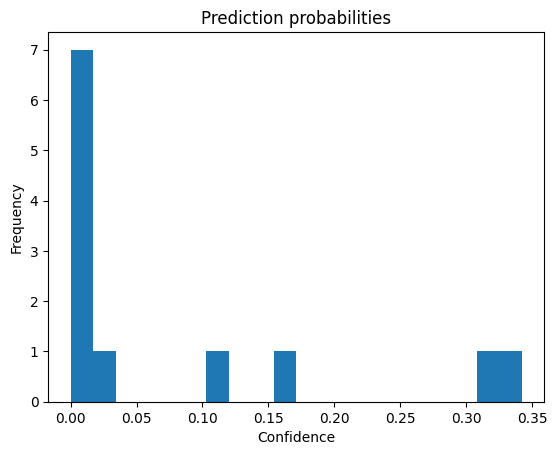

In [21]:
import matplotlib.pyplot as plt
plt.hist(pred, bins=20)
plt.title("Prediction probabilities")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.show()

In [16]:
video = preprocess_video("/home/siamai/data/Penguin/week7/test/s06_smiley.mp4")
video = normalize(video)
video = np.expand_dims(video, axis=0)
pred = model.predict(video)[0]

for label, score in zip(gesture_labels, pred):
    print(f"{label:20}: {score:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Advancing           : 0.030
Retreating          : 0.046
Enclosing           : 0.175
Spreading           : 0.000
Rising              : 0.008
Descending          : 0.274
Directing           : 0.000
Indirecting         : 0.167
Increasing Pressure : 0.076
Decreasing Pressure : 0.001
Acceleration        : 0.220
Decelerating        : 0.002


In [17]:
pred_df = pd.DataFrame(predictions, columns=gesture_labels)
result_df = pd.concat([df[["clip"]].reset_index(drop=True), pred_df], axis=1)
result_df.to_csv("soft_predictions.csv", index=False)